In [217]:
import time
import bgshr
import scipy.stats
import numpy as np
import pandas
import matplotlib.pylab as plt, matplotlib

plt.rcParams["legend.title_fontsize"] = "xx-small"
matplotlib.rc("xtick", labelsize=7)
matplotlib.rc("ytick", labelsize=7)
matplotlib.rc("axes", labelsize=8)
matplotlib.rc("axes", titlesize=8)
matplotlib.rc("legend", fontsize=6)
plt.rcParams['legend.title_fontsize'] = 'xx-small'

In [218]:
# Data Frames were generated with bgs_maps.R

In [258]:
base_path = "/home/gvbarroso/Data/momentspp/paper_2/sim_data/chr_models/"

m = 1
r = 1

models_file = base_path + "models.csv"
chr_models = pandas.read_csv(models_file, sep=",")
chr_models[chr_models["model"] == m]

,L,num_exons,exon_lengths,mean_r,mean_u,shapes_rate_u,shapes_rate_r,avg_rec_spans,avg_mut_spans,model
0,30000000.0,600,1000,1.000000e-08,1.000000e-08,3,1,1000.0,50.0,1


In [259]:
# load the lookup table
table_file = base_path + "lookup_tbl.csv.gz"
df = bgshr.Util.load_lookup_table(table_file)
df_sub = bgshr.Util.subset_lookup_table(df)
df_sub = df_sub[df_sub["s"] > -0.005]

In [260]:
# extend the lookup table with classic BGS predictions
smin = np.min(np.sort(list(set(df_sub["s"]))))
s_extend = -np.concatenate(([0], np.logspace(-6, 0, 46))) ## this may need to change with future grids
s_extend = s_extend[s_extend < smin]
df_sub = bgshr.ClassicBGS.extend_lookup_table(df_sub, s_extend)

# interpolate between recombination values in the lookup table
u_vals, s_vals, splines = bgshr.Util.generate_cubic_splines(df_sub)
max_r = max(df_sub["r"])
print("maximum recombination distance in table:", max_r)

maximum recombination distance in table: 0.5


In [261]:
ss = np.sort(list(set(df_sub["s"])))

In [262]:
u = 1.5e-8
u_nonsyn = (2.31) / (2.31 + 1) * u
u_fac = u_nonsyn / float(np.unique(chr_models["mean_u"])[0])

# DFE, from Kim et al (2017)
shape = 0.215
Ne = int(df_sub["Ns"][0]) # equilibrium model
scale = 562.1 / 2 / Ne

weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scale)

print(weights[:-1].sum())

L = float(np.unique(chr_models["L"])[0])
rec_file = base_path + "model_" + str(m) + "/rep_" + str(r) + "/rec_map.csv.gz"
rmap = bgshr.Util.load_bedgraph(rec_file, L=L)

0.9065491014110855


In [263]:
# load the exons file
efile = base_path + "model_" + str(m) + "/rep_" + str(r) + "/elements.csv.gz"
regions = pandas.read_csv(efile, sep=",")

mus = regions[regions["selected"] == 1]["u"] # avg u per exon

elements = bgshr.Util.get_elements(regions, L=L)
elements = bgshr.Util.collapse_elements(elements)
elements = bgshr.Util.break_up_elements(elements)

print("Total map length:", rmap(L))
print("Number of exons:", len(elements))

Total map length: 0.2995439781023954
Number of exons: 603


In [264]:
spacing = 1000
xs = np.arange(500, L, spacing)
time1 = time.time()
Bs = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, L=L, u=mus, rmap=rmap, elements=elements, max_r=0.5)
time2 = time.time()
print(time2 - time1)

17.795174598693848


In [281]:
B = bgshr.Util.integrate_with_weights(Bs, weights[:-1], u_fac=u_fac)
B2 = B # handy when n_ter = 0

array([0.98023869, 0.97966385, 0.9790781 , ..., 0.98446689, 0.98450778,
       0.98478158])

In [279]:
# interference correction for the 50Mb segment
# this takes a while
bmap = scipy.interpolate.CubicSpline(xs, B, bc_type="natural")
n_iter = 0
for i in range(n_iter):
    print("running iteration", i)
    rmap2 = bgshr.Util.adjust_recombination_map(rmap, bmap)
    time1 = time.time()
    Bs2 = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, L=L, rmap=rmap2, elements=elements, max_r=0.5, bmap=bmap)
    time2 = time.time()
    B2 = bgshr.Util.integrate_with_weights(Bs2, weights[:-1], u_fac=u_fac)
    print("finished iteration", i, "in", time2 - time1, "seconds")
    bmap = scipy.interpolate.CubicSpline(xs, B2, bc_type="natural")

running iteration 0
finished iteration 0 in 38.29618310928345 seconds


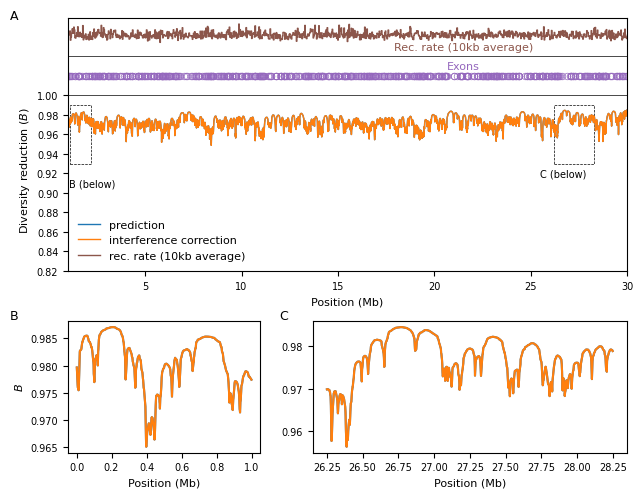

In [282]:
fig = plt.figure(figsize=(6.5, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax1 = plt.subplot2grid((8, 5), (0, 0), colspan=5, rowspan=5)
ax2 = plt.subplot2grid((8, 5), (5, 0), colspan=2, rowspan=3)
ax3 = plt.subplot2grid((8, 5), (5, 2), colspan=3, rowspan=3)

ax1.plot(xs / 1e6, B, lw=1, label="prediction")
ax1.plot(xs / 1e6, B2, lw=1, label="interference correction")
xlim = ax1.get_xlim()
ax1.hlines([1, 1.04], xlim[0], xlim[-1], "black", lw=0.5)

labeled = False
for e in elements:
    if labeled is False:
        label = "exons"
        labeled = True
    else:
        label = None
    x = np.mean([e[0], e[1]])
    L = e[1] - e[0]
    ax1.plot(x / 1e6, 1.02, "o", ms=0.15 * L ** 0.5, markerfacecolor="none", color=colors[4], markeredgewidth=0.5)

l = 10000
ax1.step(np.linspace(1, 30, 10000000 // l), 
         1.05 + 400000 * np.diff(rmap(np.linspace(1, 30000000, 10000000 // l + 1))) / l, 
         lw=1, color=colors[5],
         label="rec. rate (10kb average)"
        )
         
ax1.set_xlabel("Position (Mb)")
ax1.set_ylabel("Diversity reduction ($B$)")
ax1.yaxis.set_label_coords(-0.065, 0.4)
ax1.set_xlim(1, 30)
ax1.set_yticks(np.arange(0.82, 1.01, 0.02))
ax1.legend(frameon=False, fontsize=8)

rect = matplotlib.patches.Rectangle((1.1, 0.93), 1.1, 0.06, linestyle="--", edgecolor="k", lw=0.5, facecolor="none")
ax1.add_patch(rect)
ax1.text(2.25, 0.91, "B (below)", va="center", ha="center", fontsize=7)

rect2 = matplotlib.patches.Rectangle((26.2, 0.93), 2.1, 0.06, linestyle="--", edgecolor="k", lw=0.5, facecolor="none")
ax1.add_patch(rect2)
ax1.text(26.7, 0.92, "C (below)", va="center", ha="center", fontsize=7)

ax1.text(21.5, 1.05, "Rec. rate (10kb average)", va="center", ha="center", color=colors[5], fontsize=8)
ax1.text(21.5, 1.03, "Exons", va="center", ha="center", color=colors[4], fontsize=8)

ax2.plot(xs[1:1000] / 1e6, B[1:1000], lw=1.5, label="prediction")
ax2.plot(xs[1:1000] / 1e6, B2[1:1000], lw=1.5, label="interference correction")
ax3.plot(xs[26250:28250] / 1e6, B[26250:28250], lw=1.5, label="prediction")
ax3.plot(xs[26250:28250] / 1e6, B2[26250:28250], lw=1.5, label="prediction")

ax2.set_xlabel("Position (Mb)")
ax3.set_xlabel("Position (Mb)")
ax2.set_ylabel("$B$")

fig.text(0.025, 0.975, "A", va="center", ha="center", fontsize=9)
fig.text(0.025, 0.375, "B", va="center", ha="center", fontsize=9)
fig.text(0.440, 0.375, "C", va="center", ha="center", fontsize=9)

fig.tight_layout()
fout = base_path + "model_" + str(m) + "/rep_" + str(r) + "/chr_flat_mu.png"
plt.savefig(fout, dpi=500)

In [267]:
mut_file = base_path + "model_" + str(m) + "/rep_" + str(r) + "/mut_map.csv.gz"
mmap = pandas.read_csv(mut_file, sep=",")

# this does NOT average mu in 1kb windows
bins = np.array(mmap["end"])
bins = np.insert(bins, 0, 0)

pi0 = np.asarray(mmap["u"][np.digitize(xs, bins)] * 2 * Ne)
pi = B2 * pi0 # B2 is evaluated every 'spacing' bp

In [269]:
# 1kb
file_1kb = base_path + "model_" + str(m) + "/rep_" + str(r) + "/maps_1kb.csv.gz"
maps_1kb = pandas.read_csv(file_1kb, sep=",")
bins_1kb = np.array(maps_1kb["end"])

pi0_1kb = np.asarray(maps_1kb["avg_mut"])[np.digitize(xs, bins_1kb)] * 2 * Ne
pi_1kb = B2 * pi0_1kb # B2 is evaluated 'spacing' bp

maps_1kb.insert(len(maps_1kb.columns), "B", B2)
maps_1kb.insert(len(maps_1kb.columns), "avg_pi", pi_1kb)
fout = base_path + "model_" + str(m) + "/rep_" + str(r) + "/tbl_1kb.csv"
maps_1kb.to_csv(fout, index=False)

In [275]:
# 10 kb
file_10kb = base_path + "model_" + str(m) + "/rep_" + str(r) + "/maps_10kb.csv.gz"
maps_10kb = pandas.read_csv(file_10kb, sep=",")

B2_10kb = np.mean(B2.reshape(-1, 10), axis=1) # B2 is evaluated 'spacing' bp
pi0_10kb = np.mean(pi0_1kb.reshape(-1, 10), axis=1) 
pi_10kb = B2_10kb * pi0_10kb

maps_10kb.insert(len(maps_10kb.columns), "B", B2_10kb)
maps_10kb.insert(len(maps_10kb.columns), "avg_pi", pi_10kb)
fout = base_path + "model_" + str(m) + "/rep_" + str(r) + "/tbl_10kb.csv"
maps_10kb.to_csv(fout, index=False)

In [271]:
# 100kb
file_100kb = base_path + "model_" + str(m) + "/rep_" + str(r) + "/maps_100kb.csv.gz"
maps_100kb = pandas.read_csv(file_100kb, sep=",")

B2_100kb = np.mean(B2.reshape(-1, 100), axis=1) # B2 is evaluated 'spacing' bp
pi0_100kb = np.mean(pi0_1kb.reshape(-1, 100), axis=1)
pi_100kb = B2_100kb * pi0_100kb

maps_100kb.insert(len(maps_100kb.columns), "B", B2_100kb)
maps_100kb.insert(len(maps_100kb.columns), "avg_pi", pi_100kb)
fout = base_path + "model_" + str(m) + "/rep_" + str(r) + "/tbl_100kb.csv"
maps_100kb.to_csv(fout, index=False)

In [ ]:
# 1Mb
file_1Mb = base_path + "model_" + str(m) + "/rep_" + str(r) + "/maps_1Mb.csv.gz"
maps_1Mb = pandas.read_csv(file_1Mb, sep=",")

B2_1Mb = np.mean(B2.reshape(-1, 1000), axis=1) # B2 is evaluated 'spacing' bp
pi0_1Mb = np.mean(pi0_1kb.reshape(-1, 1000), axis=1)
pi_1Mb = B2_1Mb * pi0_1Mb

maps_1Mb.insert(len(maps_1Mb.columns), "B", B2_1Mb)
maps_1Mb.insert(len(maps_1Mb.columns), "avg_pi", pi_1Mb)
fout = base_path + "model_" + str(m) + "/rep_" + str(r) + "/tbl_1Mb.csv"
maps_1Mb.to_csv(fout, index=False)

(1.0, 30.0)

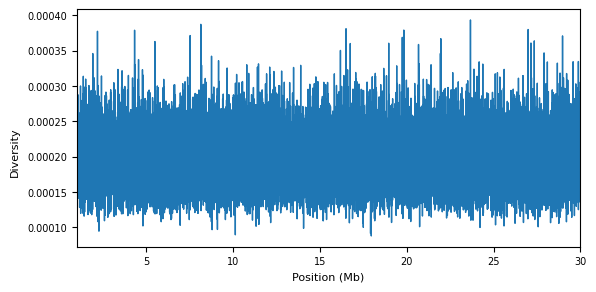

In [272]:
fig_1kb = plt.figure(figsize=(6.5, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax1 = plt.subplot2grid((8, 5), (0, 0), colspan=5, rowspan=5) # TODO fix

ax1.plot(xs / 1e6, pi_1kb, lw=1)
xlim = ax1.get_xlim()
         
ax1.set_xlabel("Position (Mb)")
ax1.set_ylabel("Diversity")
ax1.yaxis.set_label_coords(-0.1125, 0.4)
ax1.set_xlim(1, 30)

(1.0, 30.0)

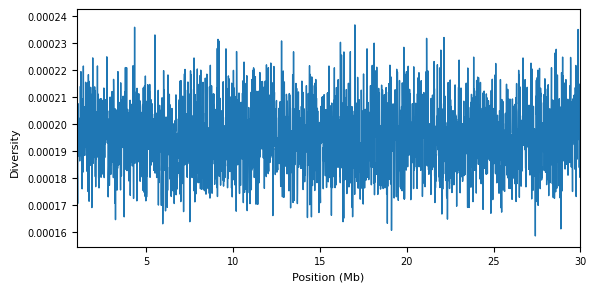

In [273]:
xs_10kb = np.mean(xs.reshape(-1, 10), axis=1)

fig_10kb = plt.figure(figsize=(6.5, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax1 = plt.subplot2grid((8, 5), (0, 0), colspan=5, rowspan=5) # TODO fix

ax1.plot(xs_10kb / 1e6, pi_10kb, lw=1)
xlim = ax1.get_xlim()
         
ax1.set_xlabel("Position (Mb)")
ax1.set_ylabel("Diversity")
ax1.yaxis.set_label_coords(-0.1125, 0.4)
ax1.set_xlim(1, 30)

(1.0, 30.0)

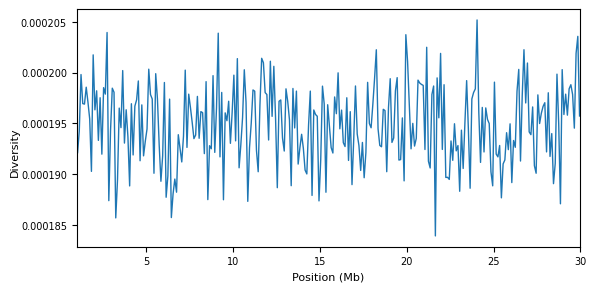

In [274]:
xs_100kb = np.mean(xs.reshape(-1, 100), axis=1)

fig_100kb = plt.figure(figsize=(6.5, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax1 = plt.subplot2grid((8, 5), (0, 0), colspan=5, rowspan=5) # TODO fix

ax1.plot(xs_100kb / 1e6, pi_100kb, lw=1)
xlim = ax1.get_xlim()
         
ax1.set_xlabel("Position (Mb)")
ax1.set_ylabel("Diversity")
ax1.yaxis.set_label_coords(-0.1125, 0.4)
ax1.set_xlim(1, 30)